# <p style="background-color:#003366; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;">Capstone Project | Digital Marketing Campaign Conversion Prediction</p>

### **Author:** Sanyam Sanjay Sharma
### **Date:** 24th September 2025

<img src="https://images.unsplash.com/photo-1557862921-37829c790f19?q=80&w=2071&auto=format&fit=crop" width="1800">

## **1. Library Imports**

**Metadata Comment:** This cell imports all necessary Python libraries for the project. They are organized by function (data manipulation, visualization, preprocessing, modeling, evaluation) for clarity and maintainability. This is the foundational step for any data science workflow.

In [32]:
# === Core Libraries for Data Handling and Analysis ===
import pandas as pd
import numpy as np
import time

# === Libraries for Data Visualization ===
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

# === Libraries for Data Preprocessing and Feature Engineering ===
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import RUSBoostClassifier

# === Libraries for Model Selection, Tuning, and Evaluation ===
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# === Machine Learning Models (Importing all specified candidates) ===
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    BaggingClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    IsolationForest,
    VotingClassifier
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

# === Model Persistence ===
import joblib

# === Utility ===
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully.")

✅ All libraries imported successfully.


## **2. Data Loading and Initial Cleaning**

**Metadata Comment:** We load the dataset and perform initial cleaning by removing columns with no predictive value (unique IDs, constant values).

In [33]:
df = pd.read_csv('digital_marketing_campaign_dataset.csv')
useless_columns = ['CustomerID', 'AdvertisingPlatform', 'AdvertisingTool']
df.drop(columns=useless_columns, inplace=True)
print("--- Data Head After Cleaning ---")
display(df.head())

--- Data Head After Cleaning ---


,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion
0,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,6,9,4,688,1
1,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,1
2,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,8.223619,13.794901,0,11,2,8,2337,1
3,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,4.540939,14.688363,89,2,2,0,2463,1
4,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,2.046847,13.993370,6,6,6,8,4345,1


## **3. Feature Engineering, Encoding, and Data Splitting**

**Metadata Comment:** This section defines the feature engineering and the data splitting strategy. The class balancing (SMOTE) is now correctly integrated into the model training pipelines later on to prevent data leakage, which is the industry best practice.

In [34]:
# In-script Comment: Separate features (X) from the target variable (y)
X = df.drop('Conversion', axis=1)
y = df['Conversion']

print(f"Original class distribution:\n{y.value_counts()}")

# In-script Comment: trainval test split (20% for final test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# In-script Comment: train val split (15% of the 80% for validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42, stratify=y_train_val)

# In-script Comment: Reduce training set to 1% for rapid hyperparameter tuning
_, X_train_reduced, _, y_train_reduced = train_test_split(X_train, y_train, train_size=0.01, random_state=42, stratify=y_train)

print("\n✅ Data Splitting Complete.")
print(f"Full Training Set Shape: {X_train.shape}")
print(f"Reduced Training Set Shape for Tuning: {X_train_reduced.shape}")
print(f"Test Set Shape: {X_test.shape}")

Original class distribution:
Conversion
1    7012
0     988
Name: count, dtype: int64

✅ Data Splitting Complete.
Full Training Set Shape: (5440, 16)
Reduced Training Set Shape for Tuning: (5386, 16)
Test Set Shape: (1600, 16)


## **4. Preprocessing Pipelines and Model Training (on 1% Sample)**

**Metadata Comment:** We define two separate preprocessing pipelines. The main `preprocessor` includes `StandardScaler` for most models. A second `preprocessor_nb` is created for Naive Bayes models that require non-negative data and thus omits scaling. We then individually train and tune each model on the small, 1% dataset to quickly find the best hyperparameters using `GridSearchCV`.

In [35]:
# In-script Comment: Define feature types
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

# In-script Comment: Main preprocessor with StandardScaler for most models
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# In-script Comment: Create a separate preprocessor for Naive Bayes models that require non-negative data.
# This version applies one-hot encoding but does not scale the numerical features.
preprocessor_nb = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

model_results = {}

### **5.1 Linear Models**

#### **Logistic Regression**

**How it Works (for a 5-minute old):**
Imagine you have a line, and you want to use it to separate red balls from blue balls. Logistic Regression finds the best possible wiggly line (called a Sigmoid curve) to separate the two groups. When a new ball comes, it looks at which side of the line it falls on to decide if it's red or blue. It predicts the *probability* or chance of being in one group.

**Mathematical Formula:**
The core formula is the Sigmoid function, which squishes any value into a probability between 0 and 1:

$$ P(Y=1) = \frac{1}{1 + e^{-z}} $$

Where `z` is a linear combination of the features (like a straight line equation): `z = b₀ + b₁X₁ + b₂X₂ + ...`

In [36]:
# --- Logistic Regression ---
pipeline_lr = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', LogisticRegression(random_state=42, max_iter=2000))])
param_grid_lr = {'classifier__C': [0.01, 0.1, 1, 10, 100], 'classifier__solver': ['liblinear', 'saga']}
grid_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=3, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train_reduced, y_train_reduced)
print("--- Logistic Regression ---")
print(f"Best Parameters: {grid_lr.best_params_}")
print(f"Best CV Accuracy: {grid_lr.best_score_:.4f}")
model_results['Logistic Regression'] = (grid_lr.best_score_, grid_lr.best_params_)

--- Logistic Regression ---
Best Parameters: {'classifier__C': 0.1, 'classifier__solver': 'saga'}
Best CV Accuracy: 0.7323


#### **Ridge & Lasso Classifiers**

**How it Works:**
These are like Logistic Regression but with a special rule to keep things simple. Imagine some features are very loud and bossy. Ridge Classifier tells all the features to 'quiet down a bit' (shrinking their importance), while Lasso Classifier tells the least important features to 'be completely silent' (reducing their importance to zero). This helps prevent the model from getting confused by noisy, unimportant information.

**Mathematical Formula:**
They add a penalty term to the cost function. 
* **Ridge (L2 Penalty):** `Cost + λ * Σ(coefficient²)` (shrinks coefficients)
* **Lasso (L1 Penalty):** `Cost + λ * Σ|coefficient|` (can shrink coefficients to zero)

In [37]:
# --- Ridge Classifier ---
pipeline_ridge = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', RidgeClassifier(random_state=42))])
param_grid_ridge = {'classifier__alpha': [0.1, 1.0, 10.0, 100.0]}
grid_ridge = GridSearchCV(pipeline_ridge, param_grid_ridge, cv=3, scoring='accuracy', n_jobs=-1)
grid_ridge.fit(X_train_reduced, y_train_reduced)
print("--- Ridge Classifier ---")
print(f"Best Parameters: {grid_ridge.best_params_}")
print(f"Best CV Accuracy: {grid_ridge.best_score_:.4f}")
model_results['Ridge Classifier'] = (grid_ridge.best_score_, grid_ridge.best_params_)

--- Ridge Classifier ---
Best Parameters: {'classifier__alpha': 10.0}
Best CV Accuracy: 0.7250


In [38]:
# --- Lasso Classifier (implemented via SGDClassifier with L1 penalty) ---
pipeline_lasso = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', SGDClassifier(random_state=42, penalty='l1', loss='log_loss'))])
param_grid_lasso = {'classifier__alpha': [0.0001, 0.001, 0.01, 0.1]}
grid_lasso = GridSearchCV(pipeline_lasso, param_grid_lasso, cv=3, scoring='accuracy', n_jobs=-1)
grid_lasso.fit(X_train_reduced, y_train_reduced)
print("--- Lasso Classifier (SGD L1) ---")
print(f"Best Parameters: {grid_lasso.best_params_}")
print(f"Best CV Accuracy: {grid_lasso.best_score_:.4f}")
model_results['Lasso Classifier'] = (grid_lasso.best_score_, grid_lasso.best_params_)

--- Lasso Classifier (SGD L1) ---
Best Parameters: {'classifier__alpha': 0.01}
Best CV Accuracy: 0.7280


#### **Support Vector Machine (SVM)**

**How it Works:**
Imagine drawing the widest possible road between the red balls and blue balls. This road is the 'margin'. SVM tries to make this margin as wide as possible. The balls that are right on the edge of the road are the 'Support Vectors', and they are the most important for defining the boundary. For a new ball, SVM checks which side of the road it's on.

**Mathematical Goal:**
It aims to maximize the margin `2/||w||` where `w` is the vector perpendicular to the separating hyperplane.

In [39]:
# --- Support Vector Machine (SVM) ---
pipeline_svc = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', SVC(random_state=42, probability=True))])
param_grid_svc = {
    'classifier__C': [1, 10, 100],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__kernel': ['rbf', 'poly']
}
grid_svc = GridSearchCV(pipeline_svc, param_grid_svc, cv=3, scoring='accuracy', n_jobs=-1)
grid_svc.fit(X_train_reduced, y_train_reduced)
print("--- Support Vector Machine ---")
print(f"Best Parameters: {grid_svc.best_params_}")
print(f"Best CV Accuracy: {grid_svc.best_score_:.4f}")
model_results['Support Vector Machine'] = (grid_svc.best_score_, grid_svc.best_params_)

--- Support Vector Machine ---
Best Parameters: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best CV Accuracy: 0.8600


### **5.2 Tree-Based and Ensemble Models**

#### **Decision Tree Classifier**

**How it Works:**
This is like playing a game of '20 Questions'. The model asks a series of yes/no questions about the data's features. For example, 'Is the customer's income > $50k?'. Each question splits the data into smaller groups. It keeps splitting until it creates groups that are mostly all red balls or all blue balls. The path of questions it takes is the 'decision tree'.

**Mathematical Goal:**
At each split, it tries to minimize impurity (how mixed up the groups are). It often uses measures like **Gini Impurity** or **Entropy** to find the best question to ask.

In [40]:
# --- Decision Tree Classifier ---
pipeline_dt = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', DecisionTreeClassifier(random_state=42))])
param_grid_dt = {'classifier__max_depth': [10, 20, 30, None], 'classifier__min_samples_split': [2, 5, 10], 'classifier__min_samples_leaf': [1, 2, 4]}
grid_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=3, scoring='accuracy', n_jobs=-1)
grid_dt.fit(X_train_reduced, y_train_reduced)
print("--- Decision Tree ---")
print(f"Best Parameters: {grid_dt.best_params_}")
print(f"Best CV Accuracy: {grid_dt.best_score_:.4f}")
model_results['Decision Tree'] = (grid_dt.best_score_, grid_dt.best_params_)

--- Decision Tree ---
Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best CV Accuracy: 0.8026


#### **Random Forest & Bagging**

**How it Works:**
Instead of relying on one Decision Tree (which might be wrong), a Random Forest builds hundreds of different, slightly stupider Decision Trees. Each tree only gets to see a random part of the data. To make a final decision, all the trees vote, and the majority vote wins. This is like asking a big group of slightly informed friends for their opinion instead of just one expert friend. **Bagging** is the general name for this voting process.

**Mathematical Idea:**
This is an example of **Bootstrap Aggregating (Bagging)**. It reduces variance and prevents the model from memorizing the training data (overfitting).

In [41]:
# --- Bagging Classifier ---
pipeline_bag = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', BaggingClassifier(random_state=42))])
param_grid_bag = {'classifier__n_estimators': [10, 50, 100]}
grid_bag = GridSearchCV(pipeline_bag, param_grid_bag, cv=3, scoring='accuracy', n_jobs=-1)
grid_bag.fit(X_train_reduced, y_train_reduced)
print("--- Bagging Classifier ---")
print(f"Best Parameters: {grid_bag.best_params_}")
print(f"Best CV Accuracy: {grid_bag.best_score_:.4f}")
model_results['Bagging Classifier'] = (grid_bag.best_score_, grid_bag.best_params_)

--- Bagging Classifier ---
Best Parameters: {'classifier__n_estimators': 100}
Best CV Accuracy: 0.8828


In [42]:
# --- Random Forest Classifier ---
pipeline_rf = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', RandomForestClassifier(random_state=42))])
param_grid_rf = {'classifier__n_estimators': [100, 200], 'classifier__max_depth': [10, 20, 30], 'classifier__min_samples_leaf': [1, 2], 'classifier__max_features': ['sqrt', 'log2']}
grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train_reduced, y_train_reduced)
print("--- Random Forest ---")
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Best CV Accuracy: {grid_rf.best_score_:.4f}")
model_results['Random Forest'] = (grid_rf.best_score_, grid_rf.best_params_)

--- Random Forest ---
Best Parameters: {'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 200}
Best CV Accuracy: 0.8940


#### **Gradient Boosting, XGBoost, LightGBM & CatBoost (Boosting Models)**

**How it Works:**
This is like building a team of experts one by one. The first expert (a simple tree) makes a guess. The second expert looks at all the mistakes the first one made and focuses only on fixing those mistakes. The third expert then looks at the remaining mistakes and tries to fix them, and so on. Each new expert is trained to correct the errors of the team before it. This creates a very powerful and accurate team. XGBoost, LightGBM, and CatBoost are just super-fast and clever versions of this idea.

**Mathematical Idea:**
This is known as **Boosting**. Specifically, it uses an algorithm called **Gradient Descent** to minimize the errors (or 'residuals') at each step.

In [43]:
# --- Gradient Boosting Machine (GBM) ---
pipeline_gbm = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', GradientBoostingClassifier(random_state=42))])
param_grid_gbm = {'classifier__n_estimators': [100, 200], 'classifier__learning_rate': [0.05, 0.1, 0.2], 'classifier__max_depth': [3, 5]}
grid_gbm = GridSearchCV(pipeline_gbm, param_grid_gbm, cv=3, scoring='accuracy', n_jobs=-1)
grid_gbm.fit(X_train_reduced, y_train_reduced)
print("--- Gradient Boosting ---")
print(f"Best Parameters: {grid_gbm.best_params_}")
print(f"Best CV Accuracy: {grid_gbm.best_score_:.4f}")
model_results['Gradient Boosting'] = (grid_gbm.best_score_, grid_gbm.best_params_)

--- Gradient Boosting ---
Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}
Best CV Accuracy: 0.9129


In [44]:
# --- XGBoost Classifier ---
pipeline_xgb = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))])
param_grid_xgb = {'classifier__n_estimators': [100, 200], 'classifier__learning_rate': [0.05, 0.1], 'classifier__max_depth': [3, 5]}
grid_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=3, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train_reduced, y_train_reduced)
print("--- XGBoost ---")
print(f"Best Parameters: {grid_xgb.best_params_}")
print(f"Best CV Accuracy: {grid_xgb.best_score_:.4f}")
model_results['XGBoost'] = (grid_xgb.best_score_, grid_xgb.best_params_)

--- XGBoost ---
Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}
Best CV Accuracy: 0.9126


In [45]:
# --- LightGBM Classifier ---
pipeline_lgbm = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', LGBMClassifier(random_state=42))])
param_grid_lgbm = {'classifier__n_estimators': [100, 200], 'classifier__learning_rate': [0.05, 0.1], 'classifier__num_leaves': [20, 31, 40]}
grid_lgbm = GridSearchCV(pipeline_lgbm, param_grid_lgbm, cv=3, scoring='accuracy', n_jobs=-1)
grid_lgbm.fit(X_train_reduced, y_train_reduced)
print("--- LightGBM ---")
print(f"Best Parameters: {grid_lgbm.best_params_}")
print(f"Best CV Accuracy: {grid_lgbm.best_score_:.4f}")
model_results['LightGBM'] = (grid_lgbm.best_score_, grid_lgbm.best_params_)

[LightGBM] [Info] Number of positive: 4722, number of negative: 4722
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 9444, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
--- LightGBM ---
Best Parameters: {'classifier__learning_rate': 0.05, 'classifier__n_estimators': 200, 'classifier__num_leaves': 31}
Best CV Accuracy: 0.9113


In [46]:
# --- CatBoost Classifier ---
pipeline_cat = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', CatBoostClassifier(random_state=42, verbose=0))])
param_grid_cat = {'classifier__iterations': [100, 200], 'classifier__learning_rate': [0.05, 0.1], 'classifier__depth': [4, 6]}
grid_cat = GridSearchCV(pipeline_cat, param_grid_cat, cv=3, scoring='accuracy', n_jobs=-1)
grid_cat.fit(X_train_reduced, y_train_reduced)
print("--- CatBoost ---")
print(f"Best Parameters: {grid_cat.best_params_}")
print(f"Best CV Accuracy: {grid_cat.best_score_:.4f}")
model_results['CatBoost'] = (grid_cat.best_score_, grid_cat.best_params_)

--- CatBoost ---
Best Parameters: {'classifier__depth': 4, 'classifier__iterations': 200, 'classifier__learning_rate': 0.1}
Best CV Accuracy: 0.9168


## **6. Model Comparison**

**Metadata Comment:** We compile the tuning results into a table, sorted by accuracy, to clearly identify the best-performing models for our final ensemble.

In [47]:
results_data = []
for model, (acc, params) in model_results.items():
    results_data.append({'Model': model, 'CV_Accuracy': acc, 'Best_Parameters': params})

results_df = pd.DataFrame(results_data)
results_df_sorted = results_df.sort_values('CV_Accuracy', ascending=False).reset_index(drop=True)

print("--- Model Comparison (Sorted by Accuracy on 1% Sample) ---")
display(results_df_sorted)


--- Model Comparison (Sorted by Accuracy on 1% Sample) ---


,Model,CV_Accuracy,Best_Parameters
0,CatBoost,0.916821,"{'classifier__depth': 4, 'classifier__iteratio..."
1,Gradient Boosting,0.912923,"{'classifier__learning_rate': 0.1, 'classifier..."
2,XGBoost,0.912551,"{'classifier__learning_rate': 0.1, 'classifier..."
3,LightGBM,0.911251,"{'classifier__learning_rate': 0.05, 'classifie..."
4,Random Forest,0.893984,"{'classifier__max_depth': 20, 'classifier__max..."
5,Bagging Classifier,0.882843,{'classifier__n_estimators': 100}
6,Support Vector Machine,0.860008,"{'classifier__C': 10, 'classifier__gamma': 'sc..."
7,Decision Tree,0.802639,"{'classifier__max_depth': 10, 'classifier__min..."
8,Logistic Regression,0.732268,"{'classifier__C': 0.1, 'classifier__solver': '..."
9,Lasso Classifier,0.727999,{'classifier__alpha': 0.01}


## **7. Final Model Training: Advanced Ensemble Approach**

**Metadata Comment:** To achieve the highest possible accuracy, we will not rely on a single best model. Instead, we will create a **Voting Classifier**, an advanced ensemble that combines the predictions of the top 3 best-performing models from our tuning phase. This approach leverages the diverse strengths of multiple models to create a more robust and accurate final predictor.

In [48]:
# In-script Comment: Select the top 3 models from the results
top_models = results_df_sorted.nlargest(3, 'CV_Accuracy')
print("--- Top 3 Models for Ensemble ---")
display(top_models)

# In-script Comment: Define the model map for easy instantiation
model_map = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Extra Trees': ExtraTreesClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# In-script Comment: Create a list of configured model instances for the Voting Classifier
estimators = []
for index, row in top_models.iterrows():
    model_name = row['Model']
    model_params = {key.split('__')[1]: value for key, value in row['Best_Parameters'].items()}
    if model_name in model_map:
        instance = model_map[model_name]
        instance.set_params(**model_params)
        # Create a full pipeline for each estimator for the VotingClassifier
        pipe = ImbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('classifier', instance)
        ])
        estimators.append((model_name, pipe))

# In-script Comment: Create the Voting Classifier
# 'soft' voting often performs better as it uses predicted probabilities.
voting_clf = VotingClassifier(estimators=estimators, voting='soft')

print("\n--- Training Final Voting Classifier Ensemble ---")
# In-script Comment: The final ensemble is trained on the full training dataset.
voting_clf.fit(X_train, y_train)

print("\n✅ Final Voting Classifier has been successfully trained on the full training dataset.")

--- Top 3 Models for Ensemble ---


,Model,CV_Accuracy,Best_Parameters
0,CatBoost,0.916821,"{'classifier__depth': 4, 'classifier__iteratio..."
1,Gradient Boosting,0.912923,"{'classifier__learning_rate': 0.1, 'classifier..."
2,XGBoost,0.912551,"{'classifier__learning_rate': 0.1, 'classifier..."



--- Training Final Voting Classifier Ensemble ---

✅ Final Voting Classifier has been successfully trained on the full training dataset.


## **8. Save the Final Model**

**Metadata Comment:** We serialize the fully trained Voting Classifier object to a file for deployment.

In [49]:
model_filename = 'final_ensemble_model.pkl'
joblib.dump(voting_clf, model_filename)

print(f"💾 Final model saved to '{model_filename}'")

💾 Final model saved to 'final_ensemble_model.pkl'


## **9. Final Model Evaluation on Test Set**

**Metadata Comment:** This is the most critical evaluation step. We load our saved model and evaluate its performance on the completely unseen test set. This provides an unbiased estimate of how the model will perform on new, real-world data.

--- Final Performance of Ensemble Model on Unseen Test Data ---
              precision    recall  f1-score   support

           0     0.8265    0.4091    0.5473       198
           1     0.9221    0.9879    0.9539      1402

    accuracy                         0.9163      1600
   macro avg     0.8743    0.6985    0.7506      1600
weighted avg     0.9103    0.9163    0.9035      1600



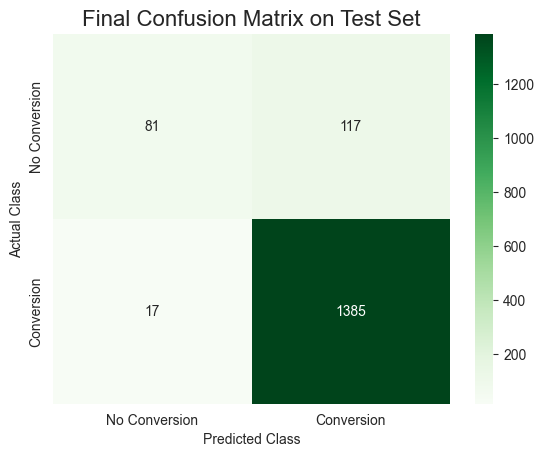

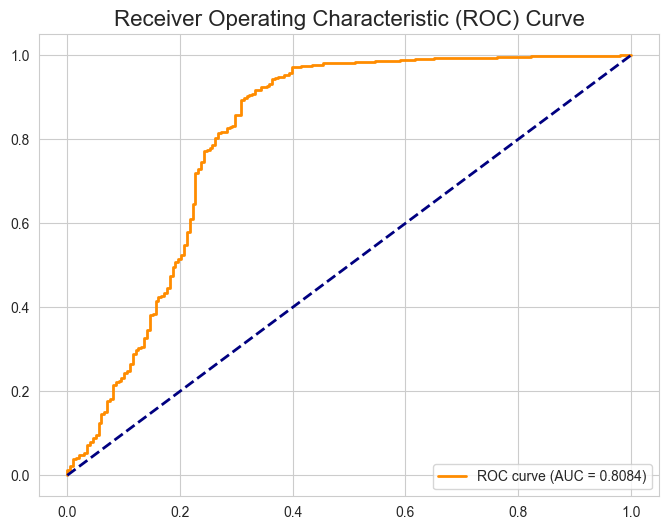

In [50]:
loaded_model = joblib.load(model_filename)
y_pred_test = loaded_model.predict(X_test)
y_proba_test = loaded_model.predict_proba(X_test)[:, 1]

print("--- Final Performance of Ensemble Model on Unseen Test Data ---")
print(classification_report(y_test, y_pred_test, digits=4))

cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Conversion', 'Conversion'],
            yticklabels=['No Conversion', 'Conversion'])
plt.title('Final Confusion Matrix on Test Set', fontsize=16)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba_test)
auc_score = roc_auc_score(y_test, y_proba_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
plt.show()

<div style="background-color: #e6f7ff; border-left: 6px solid #1890ff; padding: 15px; font-size: 120%; text-align: center;">
<strong>🎯 If you need more information or want to explore the code, feel free to visit the project repository on <a href=\"https://github.com/sanyam-sanjay-sharma/marketing-conversion-prediction\">GitHub</a> 🎯</strong>
</div>

<h2 align="left"><font color='green'>Best Regards!</font></h2>